# SVG → JSON → Semantic Export (with Optional JSON Patch)
This notebook mirrors your original structure and adds a single optional patch step after Step 3.


In [1]:
! pip install shapely

Defaulting to user installation because normal site-packages is not writeable


In [2]:
! pip install svgpathtools

Defaulting to user installation because normal site-packages is not writeable


CLASSIFY ONLY RECTANGLES

In [3]:
# !pip install svgpathtools shapely

import math, json
from svgpathtools import svg2paths2
from shapely.geometry import Polygon, LineString
from shapely.ops import unary_union

svg_file = "rect windows-01.svg"
print("Selected:", svg_file)

def sample_points(path, n=300):
    """Sample n points along an svgpathtools path."""
    return [(z.real, z.imag) for z in (path.point(i/(n-1)) for i in range(n))]

def classify(svg, area_thresh=0.85, hausdorff_thresh=5.0):
    paths, attrs, _ = svg2paths2(svg)
    results = []

    for i,(p,a) in enumerate(zip(paths,attrs)):
        pts = sample_points(p, 300)

        # close polygon
        if pts[0] != pts[-1]:
            pts.append(pts[0])

        poly = Polygon(pts).buffer(0)  # buffer(0) cleans artifacts
        if not poly.is_valid or poly.is_empty:
            continue

        # get minimum rotated rectangle
        rect = poly.minimum_rotated_rectangle

        # area ratio
        area_ratio = poly.area / rect.area if rect.area > 0 else 0

        # hausdorff distance
        hd = poly.hausdorff_distance(rect)

        is_rect = (area_ratio > area_thresh) and (hd < hausdorff_thresh)

        result = {
            "id": a.get("id", f"elem_{i}"),
            "area_ratio": round(area_ratio,3),
            "hausdorff": round(hd,2),
            "is_rectangle": bool(is_rect),
            "classification": "rectangle" if is_rect else "not_rectangle"
        }
        results.append(result)
        print(f"{result['id']} → {result['classification']} "
              f"(area_ratio={result['area_ratio']}, hd={result['hausdorff']})")

    print("\nJSON result:")
    print(json.dumps(results, indent=2))

# --- Run ---
classify(svg_file)



Selected: rect windows-01.svg
elem_0 → not_rectangle (area_ratio=0.86, hd=308.36)
elem_1 → rectangle (area_ratio=0.975, hd=3.78)
elem_2 → rectangle (area_ratio=0.972, hd=2.71)
elem_3 → rectangle (area_ratio=0.99, hd=3.19)
elem_4 → rectangle (area_ratio=0.977, hd=2.79)
elem_5 → rectangle (area_ratio=0.985, hd=2.27)
elem_6 → rectangle (area_ratio=0.968, hd=3.53)
elem_7 → rectangle (area_ratio=0.982, hd=2.26)
elem_8 → rectangle (area_ratio=0.982, hd=2.98)
elem_9 → rectangle (area_ratio=0.974, hd=2.59)
elem_10 → rectangle (area_ratio=0.985, hd=3.39)
elem_11 → rectangle (area_ratio=0.972, hd=2.64)
elem_12 → rectangle (area_ratio=0.969, hd=2.97)

JSON result:
[
  {
    "id": "elem_0",
    "area_ratio": 0.86,
    "hausdorff": 308.36,
    "is_rectangle": false,
    "classification": "not_rectangle"
  },
  {
    "id": "elem_1",
    "area_ratio": 0.975,
    "hausdorff": 3.78,
    "is_rectangle": true,
    "classification": "rectangle"
  },
  {
    "id": "elem_2",
    "area_ratio": 0.972,
    "ha

CLASSIFY CIRCLES AND RECTANGLES

In [11]:
# !pip install svgpathtools shapely

import math, json
from svgpathtools import svg2paths2
from shapely.geometry import Polygon, Point

svg_file = "rect windows with circles-01.svg"
print("Selected:", svg_file)

def sample_points(path, n=300):
    return [(z.real, z.imag) for z in (path.point(i/(n-1)) for i in range(n))]

def circle_metrics(poly):
    """Fit a circle from centroid and check closeness."""
    centroid = poly.centroid
    cx, cy = centroid.x, centroid.y
    # average radius
    coords = list(poly.exterior.coords)
    dists = [math.hypot(x-cx, y-cy) for x,y in coords]
    r = sum(dists)/len(dists)
    circle = Point(cx,cy).buffer(r, resolution=256)  # high-res circle
    area_ratio = poly.area / (math.pi*r*r) if r > 0 else 0
    hd = poly.hausdorff_distance(circle)
    return area_ratio, hd, circle

def classify(svg,
             rect_area_thresh=0.85, rect_hd_thresh=5.0,
             circ_area_thresh=0.85, circ_hd_thresh=5.0):
    paths, attrs, _ = svg2paths2(svg)
    results = []

    for i,(p,a) in enumerate(zip(paths,attrs)):
        pts = sample_points(p, 300)
        if pts[0] != pts[-1]:
            pts.append(pts[0])

        poly = Polygon(pts).buffer(0)
        if not poly.is_valid or poly.is_empty:
            continue

        # --- Rectangle test ---
        rect = poly.minimum_rotated_rectangle
        rect_area_ratio = poly.area / rect.area if rect.area > 0 else 0
        rect_hd = poly.hausdorff_distance(rect)
        is_rect = (rect_area_ratio > rect_area_thresh) and (rect_hd < rect_hd_thresh)

        # --- Circle test ---
        circ_area_ratio, circ_hd, circle = circle_metrics(poly)
        is_circ = (circ_area_ratio > circ_area_thresh) and (circ_hd < circ_hd_thresh)

        if is_rect:
            cls = "rectangle"
        elif is_circ:
            cls = "circle"
        else:
            cls = "not_rectangle_or_circle"

        result = {
            "id": a.get("id", f"elem_{i}"),
            "rect_area_ratio": round(rect_area_ratio,3),
            "rect_hd": round(rect_hd,2),
            "circ_area_ratio": round(circ_area_ratio,3),
            "circ_hd": round(circ_hd,2),
            "classification": cls
        }
        results.append(result)
        print(f"{result['id']} → {cls} "
              f"(rect_area_ratio={result['rect_area_ratio']}, rect_hd={result['rect_hd']}, "
              f"circ_area_ratio={result['circ_area_ratio']}, circ_hd={result['circ_hd']})")

    print("\nJSON result:")
    print(json.dumps(results, indent=2))

# --- Run ---
classify(svg_file)


Selected: rect windows with circles-01.svg
elem_0 → not_rectangle_or_circle (rect_area_ratio=0.898, rect_hd=246.41, circ_area_ratio=0.9, circ_hd=310.27)
elem_1 → rectangle (rect_area_ratio=0.975, rect_hd=3.78, circ_area_ratio=0.584, circ_hd=43.89)
elem_2 → rectangle (rect_area_ratio=0.972, rect_hd=2.71, circ_area_ratio=0.564, circ_hd=44.73)
elem_3 → rectangle (rect_area_ratio=0.99, rect_hd=3.19, circ_area_ratio=0.576, circ_hd=43.52)
elem_4 → rectangle (rect_area_ratio=0.977, rect_hd=2.79, circ_area_ratio=0.598, circ_hd=41.7)
elem_5 → rectangle (rect_area_ratio=0.968, rect_hd=3.53, circ_area_ratio=0.561, circ_hd=43.72)
elem_6 → rectangle (rect_area_ratio=0.982, rect_hd=2.26, circ_area_ratio=0.579, circ_hd=42.61)
elem_7 → rectangle (rect_area_ratio=0.982, rect_hd=2.98, circ_area_ratio=0.558, circ_hd=43.7)
elem_8 → rectangle (rect_area_ratio=0.974, rect_hd=2.59, circ_area_ratio=0.558, circ_hd=42.97)
elem_9 → rectangle (rect_area_ratio=0.985, rect_hd=3.39, circ_area_ratio=0.535, circ_hd=44

CLASSIFY CIRCLES AND RECTANGLES AND POLYGONS

In [ ]:
! pip install svgpathtools numpy

In [45]:
# !pip install svgpathtools shapely

import math, json, os
from svgpathtools import svg2paths2
from shapely.geometry import Polygon, Point, LineString

svg_file = "multi-01.svg"
print("Selected:", svg_file)

# --- Helpers ---
def sample_points(path, n=300):
    return [(float(z.real), float(z.imag)) for z in (path.point(i/(n-1)) for i in range(n))]

def angle_deg(a, b, c):
    bax, bay = a[0]-b[0], a[1]-b[1]
    bcx, bcy = c[0]-b[0], c[1]-b[1]
    na, nb = math.hypot(bax, bay), math.hypot(bcx, bcy)
    if na*nb == 0: return 0
    cosang = (bax*bcx + bay*bcy)/(na*nb)
    cosang = max(-1.0, min(1.0, cosang))
    return math.degrees(math.acos(cosang))

def circle_metrics(poly):
    centroid = poly.centroid
    cx, cy = centroid.x, centroid.y
    coords = list(poly.exterior.coords)
    dists = [math.hypot(x-cx, y-cy) for x,y in coords]
    r = sum(dists)/len(dists)
    circle = Point(cx,cy).buffer(r, resolution=256)
    area_ratio = poly.area / (math.pi*r*r) if r > 0 else 0
    hd = poly.hausdorff_distance(circle)
    return area_ratio, hd, (cx,cy,r)

def count_polygon_sides(poly, angle_tol=10, simplify_tol=3.0):
    simp = LineString(list(poly.exterior.coords)).simplify(simplify_tol, preserve_topology=False)
    coords = list(simp.coords)
    if len(coords) < 3: return 0, []
    if coords[0] == coords[-1]: coords = coords[:-1]
    # edge directions
    edges = []
    for i in range(len(coords)):
        x1,y1 = coords[i]; x2,y2 = coords[(i+1)%len(coords)]
        vx, vy = x2-x1, y2-y1
        norm = math.hypot(vx,vy)
        if norm > 1e-6:
            edges.append((vx/norm, vy/norm))
    dirs = []
    simp_coords = [coords[0]]
    for j,v in enumerate(edges):
        ang = math.degrees(math.atan2(v[1], v[0]))
        if not dirs:
            dirs.append(ang)
        else:
            prev = dirs[-1]
            diff = abs((ang-prev+180)%360 - 180)
            if diff > angle_tol:
                dirs.append(ang)
                simp_coords.append(coords[j])
    simp_coords.append(coords[-1])
    return len(dirs), simp_coords

# --- Main classifier ---
def classify(svg,
             rect_area_thresh=0.85, rect_hd_thresh=5.0,
             circ_area_thresh=0.85, circ_hd_thresh=5.0):
    paths, attrs, _ = svg2paths2(svg)
    results = []

    for i,(p,a) in enumerate(zip(paths,attrs)):
        pts = sample_points(p, 300)
        if pts[0] != pts[-1]: pts.append(pts[0])
        poly = Polygon(pts).buffer(0)
        if not poly.is_valid or poly.is_empty: continue

        # Rectangle test
        rect = poly.minimum_rotated_rectangle
        rect_area_ratio = poly.area / rect.area if rect.area > 0 else 0
        rect_hd = poly.hausdorff_distance(rect)
        is_rect = (rect_area_ratio > rect_area_thresh) and (rect_hd < rect_hd_thresh)

        # Circle test
        circ_area_ratio, circ_hd, circ_params = circle_metrics(poly)
        is_circ = (circ_area_ratio > circ_area_thresh) and (circ_hd < circ_hd_thresh)

        # Polygon test
        n_sides, simp_coords = count_polygon_sides(poly, angle_tol=30, simplify_tol=3.0)

        # Classification + geometry export
        if is_rect:
            cls = "rectangle"
            geom = list(rect.exterior.coords)
        elif is_circ:
            cls = "circle"
            cx,cy,r = circ_params
            geom = {"center": [round(cx,2), round(cy,2)], "radius": round(r,2)}
        elif n_sides >= 3:
            names = {3:"triangle",4:"quadrilateral",5:"pentagon",6:"hexagon"}
            cls = names.get(n_sides, f"polygon_{n_sides}_sides")
            geom = simp_coords
        else:
            cls = "unclassified"
            geom = pts  # raw if nothing else

        result = {
            "id": a.get("id", f"elem_{i}"),
            "classification": cls,
            "n_sides": n_sides,
            "rect_area_ratio": round(rect_area_ratio,3),
            "rect_hd": round(rect_hd,2),
            "circ_area_ratio": round(circ_area_ratio,3),
            "circ_hd": round(circ_hd,2),
            "geometry": geom
        }
        results.append(result)
        print(f"{result['id']} → {cls}")

    # Save JSON
    base, _ = os.path.splitext(svg)
    out_path = base + "_classified.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2)
    print(f"\nResults saved to: {out_path}")

    return results

# --- Run ---
classify(svg_file)


Selected: multi-01.svg
elem_0 → rectangle
elem_1 → rectangle
elem_2 → rectangle
elem_3 → rectangle
elem_4 → rectangle
elem_5 → rectangle
elem_6 → rectangle
elem_7 → rectangle
elem_8 → circle
elem_9 → hexagon
elem_10 → polygon_12_sides
elem_11 → polygon_7_sides

Results saved to: multi-01_classified.json


[{'id': 'elem_0',
  'classification': 'rectangle',
  'n_sides': 6,
  'rect_area_ratio': 0.975,
  'rect_hd': 3.78,
  'circ_area_ratio': 0.584,
  'circ_hd': 43.89,
  'geometry': [(303.43194714526555, 815.0091172140543),
   (302.60561383144335, 611.8242285681006),
   (269.0080979592399, 611.9608664195268),
   (269.8344312730621, 815.1457550654806),
   (303.43194714526555, 815.0091172140543)]},
 {'id': 'elem_1',
  'classification': 'rectangle',
  'n_sides': 6,
  'rect_area_ratio': 0.99,
  'rect_hd': 3.19,
  'circ_area_ratio': 0.576,
  'circ_hd': 43.52,
  'geometry': [(301.3481961883949, 522.6184026977138),
   (301.39925041041215, 322.33118492317743),
   (268.80596509895526, 322.3228767303579),
   (268.754910876938, 522.6100945048943),
   (301.3481961883949, 522.6184026977138)]},
 {'id': 'elem_2',
  'classification': 'rectangle',
  'n_sides': 5,
  'rect_area_ratio': 0.977,
  'rect_hd': 2.79,
  'circ_area_ratio': 0.598,
  'circ_hd': 41.7,
  'geometry': [(267.1417516468434, 229.34003916915484

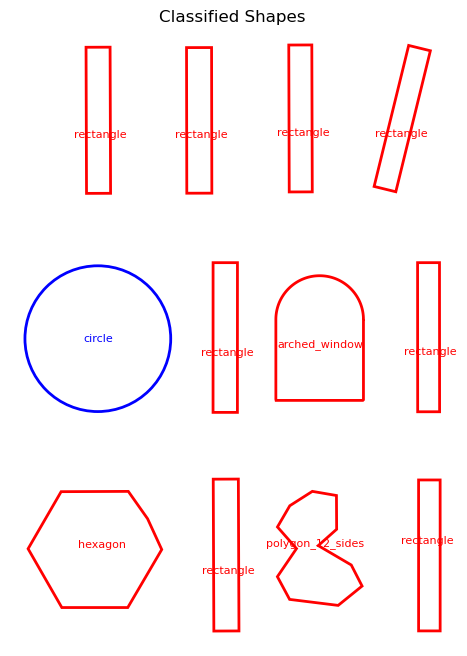

Saved visualization as classified_output.jpg


In [4]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon, Circle

# --- Load classification result ---
json_file = "multi-01_classified.json"

with open(json_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Collect all coordinates for bounding box
all_x, all_y = [], []
for shape in data:
    geom = shape["geometry"]
    if isinstance(geom, dict):  # circle
        cx, cy = geom["center"]
        r = geom["radius"]
        all_x += [cx-r, cx+r]
        all_y += [cy-r, cy+r]
    else:  # polygon
        xs, ys = zip(*geom)
        all_x += xs
        all_y += ys

xmin, xmax = min(all_x), max(all_x)
ymin, ymax = min(all_y), max(all_y)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.invert_yaxis()  # match SVG Y-down

for shape in data:
    cls = shape["classification"]
    geom = shape["geometry"]

    if cls == "circle":
        cx, cy = geom["center"]
        r = geom["radius"]
        circ = Circle((cx, cy), r, fill=False, edgecolor="blue", linewidth=2)
        ax.add_patch(circ)
        ax.text(cx, cy, cls, color="blue", ha="center", va="center", fontsize=8)
    else:
        poly = MplPolygon(geom, fill=False, edgecolor="red", linewidth=2)
        ax.add_patch(poly)
        xs, ys = zip(*geom)
        ax.text(sum(xs)/len(xs), sum(ys)/len(ys), cls,
                color="red", ha="center", va="center", fontsize=8)

ax.set_xlim(xmin-20, xmax+20)
ax.set_ylim(ymax+20, ymin-20)  # inverted y
ax.set_title("Classified Shapes")
plt.axis("off")

# --- Save to JPG safely ---
plt.savefig("classified_output.jpg", dpi=150, bbox_inches="tight")
plt.show()

print("Saved visualization as classified_output.jpg")


CLASSIFY CIRCLES, RECTANGLES, POLYGONS AND ARCHES

In [5]:
# !pip install svgpathtools shapely

import math, json, os
from svgpathtools import svg2paths2
from shapely.geometry import Polygon, Point, LineString

svg_file = "multi-01.svg"
print("Selected:", svg_file)

# --- Helpers ---
def sample_points(path, n=300):
    return [(float(z.real), float(z.imag)) for z in (path.point(i/(n-1)) for i in range(n))]

def angle_deg(a, b, c):
    bax, bay = a[0]-b[0], a[1]-b[1]
    bcx, bcy = c[0]-b[0], c[1]-b[1]
    na, nb = math.hypot(bax, bay), math.hypot(bcx, bcy)
    if na*nb == 0: return 0
    cosang = (bax*bcx + bay*bcy)/(na*nb)
    cosang = max(-1.0, min(1.0, cosang))
    return math.degrees(math.acos(cosang))

def circle_metrics(poly):
    centroid = poly.centroid
    cx, cy = centroid.x, centroid.y
    coords = list(poly.exterior.coords)
    dists = [math.hypot(x-cx, y-cy) for x,y in coords]
    r = sum(dists)/len(dists)
    circle = Point(cx,cy).buffer(r, resolution=256)
    area_ratio = poly.area / (math.pi*r*r) if r > 0 else 0
    hd = poly.hausdorff_distance(circle)
    return area_ratio, hd, (cx,cy,r)

def count_polygon_sides(poly, angle_tol=10, simplify_tol=3.0):
    simp = LineString(list(poly.exterior.coords)).simplify(simplify_tol, preserve_topology=False)
    coords = list(simp.coords)
    if len(coords) < 3: return 0, []
    if coords[0] == coords[-1]: coords = coords[:-1]
    # edge directions
    edges = []
    for i in range(len(coords)):
        x1,y1 = coords[i]; x2,y2 = coords[(i+1)%len(coords)]
        vx, vy = x2-x1, y2-y1
        norm = math.hypot(vx,vy)
        if norm > 1e-6:
            edges.append((vx/norm, vy/norm))
    dirs = []
    simp_coords = [coords[0]]
    for j,v in enumerate(edges):
        ang = math.degrees(math.atan2(v[1], v[0]))
        if not dirs:
            dirs.append(ang)
        else:
            prev = dirs[-1]
            diff = abs((ang-prev+180)%360 - 180)
            if diff > angle_tol:
                dirs.append(ang)
                simp_coords.append(coords[j])
    simp_coords.append(coords[-1])
    return len(dirs), simp_coords

def is_arched_window(poly, rect_area_ratio, circ_area_ratio):
    """
    Heuristic for arched window:
    - Shape close to rectangle in bounding box ratio
    - Also circle-like enough (top curvature).
    - Typically taller than wide.
    """
    if rect_area_ratio > 0.85 and circ_area_ratio > 0.8:
        minx, miny, maxx, maxy = poly.bounds
        w, h = maxx - minx, maxy - miny
        if h > w * 0.8:  # tall-ish
            return True
    return False

# --- Main classifier ---
def classify(svg,
             rect_area_thresh=0.85, rect_hd_thresh=5.0,
             circ_area_thresh=0.85, circ_hd_thresh=5.0):
    paths, attrs, _ = svg2paths2(svg)
    results = []

    for i,(p,a) in enumerate(zip(paths,attrs)):
        pts = sample_points(p, 300)
        if pts[0] != pts[-1]: pts.append(pts[0])
        poly = Polygon(pts).buffer(0)
        if not poly.is_valid or poly.is_empty: continue

        # Rectangle test
        rect = poly.minimum_rotated_rectangle
        rect_area_ratio = poly.area / rect.area if rect.area > 0 else 0
        rect_hd = poly.hausdorff_distance(rect)
        is_rect = (rect_area_ratio > rect_area_thresh) and (rect_hd < rect_hd_thresh)

        # Circle test
        circ_area_ratio, circ_hd, circ_params = circle_metrics(poly)
        is_circ = (circ_area_ratio > circ_area_thresh) and (circ_hd < circ_hd_thresh)

        # Polygon test
        n_sides, simp_coords = count_polygon_sides(poly, angle_tol=30, simplify_tol=3.0)

        # --- Classification + geometry export ---
        if is_rect:
            cls = "rectangle"
            geom = list(rect.exterior.coords)
        elif is_arched_window(poly, rect_area_ratio, circ_area_ratio):
            cls = "arched_window"
            geom = list(poly.exterior.coords)  # store polygon coords
        elif is_circ:
            cls = "circle"
            cx,cy,r = circ_params
            geom = {"center": [round(cx,2), round(cy,2)], "radius": round(r,2)}
        elif n_sides >= 3:
            names = {3:"triangle",4:"quadrilateral",5:"pentagon",6:"hexagon"}
            cls = names.get(n_sides, f"polygon_{n_sides}_sides")
            geom = simp_coords
        else:
            cls = "unclassified"
            geom = pts

        result = {
            "id": a.get("id", f"elem_{i}"),
            "classification": cls,
            "n_sides": n_sides,
            "rect_area_ratio": round(rect_area_ratio,3),
            "rect_hd": round(rect_hd,2),
            "circ_area_ratio": round(circ_area_ratio,3),
            "circ_hd": round(circ_hd,2),
            "geometry": geom
        }
        results.append(result)
        print(f"{result['id']} → {cls}")

    # Save JSON
    base, _ = os.path.splitext(svg)
    out_path = base + "_classified.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2)
    print(f"\nResults saved to: {out_path}")

    return results

# --- Run ---
classify(svg_file)


Selected: multi-01.svg
elem_0 → rectangle
elem_1 → rectangle
elem_2 → rectangle
elem_3 → rectangle
elem_4 → rectangle
elem_5 → rectangle
elem_6 → rectangle
elem_7 → rectangle
elem_8 → circle
elem_9 → hexagon
elem_10 → polygon_12_sides
elem_11 → arched_window

Results saved to: multi-01_classified.json


[{'id': 'elem_0',
  'classification': 'rectangle',
  'n_sides': 6,
  'rect_area_ratio': 0.975,
  'rect_hd': 3.78,
  'circ_area_ratio': 0.584,
  'circ_hd': 43.89,
  'geometry': [(303.43194714526555, 815.0091172140543),
   (302.60561383144335, 611.8242285681006),
   (269.0080979592399, 611.9608664195268),
   (269.8344312730621, 815.1457550654806),
   (303.43194714526555, 815.0091172140543)]},
 {'id': 'elem_1',
  'classification': 'rectangle',
  'n_sides': 6,
  'rect_area_ratio': 0.99,
  'rect_hd': 3.19,
  'circ_area_ratio': 0.576,
  'circ_hd': 43.52,
  'geometry': [(301.3481961883949, 522.6184026977138),
   (301.39925041041215, 322.33118492317743),
   (268.80596509895526, 322.3228767303579),
   (268.754910876938, 522.6100945048943),
   (301.3481961883949, 522.6184026977138)]},
 {'id': 'elem_2',
  'classification': 'rectangle',
  'n_sides': 5,
  'rect_area_ratio': 0.977,
  'rect_hd': 2.79,
  'circ_area_ratio': 0.598,
  'circ_hd': 41.7,
  'geometry': [(267.1417516468434, 229.34003916915484

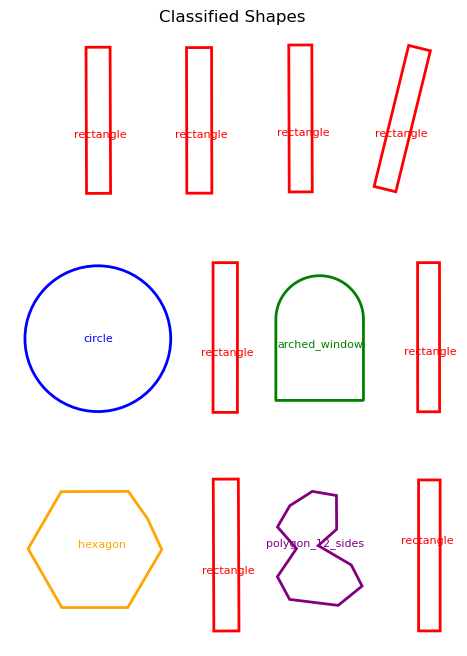

Saved visualization as classified_output.jpg


In [6]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon, Circle

# --- Load classification result ---
json_file = "multi-01_classified.json"

with open(json_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Collect all coordinates for bounding box
all_x, all_y = [], []
for shape in data:
    geom = shape["geometry"]
    if isinstance(geom, dict):  # circle
        cx, cy = geom["center"]
        r = geom["radius"]
        all_x += [cx-r, cx+r]
        all_y += [cy-r, cy+r]
    else:  # polygon-like
        xs, ys = zip(*geom)
        all_x += xs
        all_y += ys

xmin, xmax = min(all_x), max(all_x)
ymin, ymax = min(all_y), max(all_y)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.invert_yaxis()  # SVG coords have y down

# Color mapping by class
colors = {
    "rectangle": "red",
    "circle": "blue",
    "arched_window": "green",
    "triangle": "orange",
    "quadrilateral": "orange",
    "pentagon": "orange",
    "hexagon": "orange"
}

for shape in data:
    cls = shape["classification"]
    geom = shape["geometry"]
    color = colors.get(cls, "purple")  # default color for polygons

    if cls == "circle":
        cx, cy = geom["center"]
        r = geom["radius"]
        circ = Circle((cx, cy), r, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(circ)
        ax.text(cx, cy, cls, color=color, ha="center", va="center", fontsize=8)
    else:  # rectangle, arched_window, polygon
        poly = MplPolygon(geom, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(poly)
        xs, ys = zip(*geom)
        ax.text(sum(xs)/len(xs), sum(ys)/len(ys), cls,
                color=color, ha="center", va="center", fontsize=8)

ax.set_xlim(xmin-20, xmax+20)
ax.set_ylim(ymax+20, ymin-20)
ax.set_title("Classified Shapes")
plt.axis("off")

# --- Save to JPG safely ---
plt.savefig("classified_output.jpg", dpi=150, bbox_inches="tight")
plt.show()

print("Saved visualization as classified_output.jpg")


REORGANIZE JSON OUTPUT

In [7]:
import json
import os

# Input from classifier
classified_file = "multi-01_classified.json"
out_file = "multi-01_structured.json"

with open(classified_file, "r", encoding="utf-8") as f:
    shapes = json.load(f)

# --- Parameters ---
level_eps = 80  # threshold for grouping by vertical height

elements = []

# Collect baseline Y positions for grouping
ys = []
for s in shapes:
    geom = s["geometry"]
    if isinstance(geom, dict):  # circle
        cx, cy = geom["center"]
        ymin = cy - geom["radius"]
    else:  # polygon
        xs, ys_coords = zip(*geom)
        ymin = min(ys_coords)
    ys.append(ymin)

ys_sorted = sorted(ys)
levels = []
for y in ys_sorted:
    if not levels or abs(y - levels[-1]) > level_eps:
        levels.append(y)

def assign_level(ymin):
    diffs = [abs(ymin - lv) for lv in levels]
    return int(diffs.index(min(diffs)))

# --- Convert shapes to unified format ---
for i, s in enumerate(shapes):
    geom = s["geometry"]
    cls = s["classification"]

    if isinstance(geom, dict):  # circle
        cx, cy = geom["center"]
        r = geom["radius"]
        xmin, ymin = cx - r, cy - r
        w, h = 2*r, 2*r
    else:
        xs, ys_coords = zip(*geom)
        xmin, ymin, xmax, ymax = min(xs), min(ys_coords), max(xs), max(ys_coords)
        w, h = xmax - xmin, ymax - ymin

    # Assign type + shape name
    if cls == "rectangle":
        type_name, shape_name = "window", "rect"
    elif cls == "circle":
        type_name, shape_name = "window", "circle"
    elif cls == "arched_window":
        type_name, shape_name = "window", "arched"
    else:
        type_name, shape_name = "other", cls

    elem = {
        "type": type_name,
        "id": f"elem_{i}",
        "level": assign_level(ymin),
        "bbox": [xmin, ymin, w, h],
        "shape": shape_name
    }

    # Add extra geometry description
    if isinstance(geom, dict):  # circle
        elem["circle"] = {
            "center": geom["center"],
            "radius": geom["radius"]
        }
    else:  # polygon
        elem["polygon"] = geom

    elements.append(elem)

# --- Save result ---
out_data = {"elements": elements}
with open(out_file, "w", encoding="utf-8") as f:
    json.dump(out_data, f, indent=2)

print(f"Saved structured JSON → {out_file}")
print(f"Detected {len(levels)} levels with tolerance {level_eps}")


Saved structured JSON → multi-01_structured.json
Detected 3 levels with tolerance 80


CLASSIFY WITH BEZIER (NOT WORKING)

In [ ]:
import json, re, xml.etree.ElementTree as ET

INPUT_SVG = "mask_output.svg"
OUTPUT_JSON = "output/openai_svg_output.json"

tree = ET.parse(INPUT_SVG)
root = tree.getroot()
SVG_NS = "{http://www.w3.org/2000/svg}"

ALLOWED_WINDOW_SHAPES = {"rect", "circle", "polygon", "polyline", "bezier"}  # classify these as windows

def attr(el, name, default=None):
    return el.get(name) if el.get(name) is not None else default

def f(x, default=0.0):
    try: return float(x)
    except: return default

def bbox_from_points(pts):
    if not pts: return [0,0,0,0]
    xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
    x0, y0 = min(xs), min(ys)
    return [x0, y0, max(xs)-x0, max(ys)-y0]

def path_points(d):
    import re, math
    tokens = re.findall(r"[A-Za-z]|[-+]?\d*\.?\d+(?:e[-+]?\d+)?", d or "")
    i = 0
    cmd = None
    pts = []

    cur = (0.0, 0.0)
    start = (0.0, 0.0)
    prev_c2 = None      # last cubic control point (absolute)
    prev_q = None       # last quadratic control point (absolute)

    def next_numbers(n):
        nonlocal i
        out = []
        for _ in range(n):
            if i >= len(tokens) or re.match(r"[A-Za-z]", tokens[i]):
                return None
            out.append(float(tokens[i])); i += 1
        return out

    while i < len(tokens):
        t = tokens[i]
        if re.match(r"[A-Za-z]", t):
            cmd = t
            i += 1
        elif cmd is None:
            # malformed path
            break

        abs_cmd = cmd.upper()
        rel = cmd.islower()

        if abs_cmd == 'M':
            nums = next_numbers(2)
            if nums is None: break
            x, y = nums
            if rel: x += cur[0]; y += cur[1]
            cur = (x, y); start = cur
            pts.append(cur)
            prev_c2 = prev_q = None
            # subsequent pairs are implicit L
            while True:
                look = next_numbers(2)
                if look is None: break
                x, y = look
                if rel: x += cur[0]; y += cur[1]
                cur = (x, y); pts.append(cur)
                prev_c2 = prev_q = None

        elif abs_cmd == 'L':
            while True:
                nums = next_numbers(2)
                if nums is None: break
                x, y = nums
                if rel: x += cur[0]; y += cur[1]
                cur = (x, y); pts.append(cur)
                prev_c2 = prev_q = None

        elif abs_cmd == 'H':
            while True:
                nums = next_numbers(1)
                if nums is None: break
                x = nums[0]
                if rel: x += cur[0]
                cur = (x, cur[1]); pts.append(cur)
                prev_c2 = prev_q = None

        elif abs_cmd == 'V':
            while True:
                nums = next_numbers(1)
                if nums is None: break
                y = nums[0]
                if rel: y += cur[1]
                cur = (cur[0], y); pts.append(cur)
                prev_c2 = prev_q = None

        elif abs_cmd == 'C':
            while True:
                nums = next_numbers(6)
                if nums is None: break
                x1, y1, x2, y2, x, y = nums
                if rel:
                    x1 += cur[0]; y1 += cur[1]
                    x2 += cur[0]; y2 += cur[1]
                    x  += cur[0]; y  += cur[1]
                # if you want control points too, append them:
                pts.extend([(x1, y1), (x2, y2), (x, y)])
                cur = (x, y); prev_c2 = (x2, y2); prev_q = None

        elif abs_cmd == 'S':
            while True:
                nums = next_numbers(4)
                if nums is None: break
                x2, y2, x, y = nums
                if prev_c2 is not None:
                    x1r = 2*cur[0] - prev_c2[0]
                    y1r = 2*cur[1] - prev_c2[1]
                else:
                    x1r, y1r = cur
                if rel:
                    x2 += cur[0]; y2 += cur[1]
                    x  += cur[0]; y  += cur[1]
                pts.extend([(x1r, y1r), (x2, y2), (x, y)])
                cur = (x, y); prev_c2 = (x2, y2); prev_q = None

        elif abs_cmd == 'Q':
            while True:
                nums = next_numbers(4)
                if nums is None: break
                x1, y1, x, y = nums
                if rel:
                    x1 += cur[0]; y1 += cur[1]
                    x  += cur[0]; y  += cur[1]
                pts.extend([(x1, y1), (x, y)])
                cur = (x, y); prev_q = (x1, y1); prev_c2 = None

        elif abs_cmd == 'T':
            while True:
                nums = next_numbers(2)
                if nums is None: break
                x, y = nums
                if prev_q is not None:
                    x1r = 2*cur[0] - prev_q[0]
                    y1r = 2*cur[1] - prev_q[1]
                else:
                    x1r, y1r = cur
                if rel:
                    x += cur[0]; y += cur[1]
                pts.extend([(x1r, y1r), (x, y)])
                cur = (x, y); prev_q = (x1r, y1r); prev_c2 = None

        elif abs_cmd == 'Z':
            cur = start
            pts.append(cur)
            prev_c2 = prev_q = None

        else:
            # A (arc) and others not handled here
            # Skip until next command letter
            while i < len(tokens) and not re.match(r"[A-Za-z]", tokens[i]):
                i += 1

    return pts

def polygon_points(points_attr):
    s = (points_attr or "").replace(",", " ").strip()
    if not s: return []
    nums = re.findall(r"[-+]?\d*\.?\d+(?:e[-+]?\d+)?", s)
    vals = [float(n) for n in nums]
    return list(zip(vals[0::2], vals[1::2])) if len(vals) >= 2 else []

def classify_path_shape(d):
    if not d: return "custom"
    up = d.upper()
    has_bezier = any(c in up for c in ("C","S","Q","T"))
    has_arc = "A" in up
    # If not bezier/arc, assume polyline-ish (M/L/H/V/Z only)
    if has_bezier:
        return "bezier"
    if has_arc:
        return "arc"
    return "polyline"

elements = []

# Rectangles
for rect in root.iter(f"{SVG_NS}rect"):
    x = f(attr(rect,"x",0)); y = f(attr(rect,"y",0))
    w = f(attr(rect,"width",0)); h = f(attr(rect,"height",0))
    t = (attr(rect,"data-type","") or "").lower()
    shape = "rect"
    el_type = "window" if (shape in ALLOWED_WINDOW_SHAPES or "window" in t) else "other"

    print(f"Rectangle: attributes={rect.attrib}, data-type={t}, x={x}, y={y}, width={w}, height={h}")
    elements.append({
        "type": el_type,
        "id": attr(rect,"id",""),
        "level": None,
        "bbox": [x,y,w,h],
        "shape": shape
    })

# Circles
for circle in root.iter(f"{SVG_NS}circle"):
    cx = f(attr(circle,"cx",0)); cy = f(attr(circle,"cy",0)); r = f(attr(circle,"r",0))
    t = (attr(circle,"data-type","") or "").lower()
    shape = "circle"
    el_type = "window" if (shape in ALLOWED_WINDOW_SHAPES or "window" in t) else "other"

    bb = [cx - r, cy - r, 2*r, 2*r]
    print(f"Circle: attributes={circle.attrib}, data-type={t}, cx={cx}, cy={cy}, r={r}")
    elements.append({
        "type": el_type,
        "id": attr(circle,"id",""),
        "level": None,
        "bbox": bb,
        "polygon": None,
        "shape": shape
    })

# Ellipses (kept as 'other' unless you want them as windows)
for ellipse in root.iter(f"{SVG_NS}ellipse"):
    cx = f(attr(ellipse,"cx",0)); cy = f(attr(ellipse,"cy",0))
    rx = f(attr(ellipse,"rx",0)); ry = f(attr(ellipse,"ry",0))
    t = (attr(ellipse,"data-type","") or "").lower()
    shape = "ellipse"
    el_type = "window" if ("window" in t) else "other"  # change to include ellipse if desired

    bb = [cx - rx, cy - ry, 2*rx, 2*ry]
    print(f"Ellipse: attributes={ellipse.attrib}, data-type={t}, cx={cx}, cy={cy}, rx={rx}, ry={ry}")
    elements.append({
        "type": el_type,
        "id": attr(ellipse,"id",""),
        "level": None,
        "bbox": bb,
        "polygon": None,
        "shape": shape
    })

# Polygons
for poly in root.iter(f"{SVG_NS}polygon"):
    t = (attr(poly,"data-type","") or "").lower()
    pts = polygon_points(attr(poly, "points", ""))
    bb = bbox_from_points(pts)
    shape = "polygon"
    el_type = "window" if (shape in ALLOWED_WINDOW_SHAPES or "window" in t) else "other"

    print(f"Polygon: attributes={poly.attrib}, data-type={t}")
    elements.append({
        "type": el_type,
        "id": attr(poly,"id",""),
        "level": None,
        "bbox": bb,
        "polygon": pts if pts else None,
        "shape": shape
    })

# Polylines
for pl in root.iter(f"{SVG_NS}polyline"):
    t = (attr(pl,"data-type","") or "").lower()
    pts = polygon_points(attr(pl, "points", ""))
    bb = bbox_from_points(pts)
    shape = "polyline"
    el_type = "window" if (shape in ALLOWED_WINDOW_SHAPES or "window" in t) else "other"

    print(f"Polyline: attributes={pl.attrib}, data-type={t}")
    elements.append({
        "type": el_type,
        "id": attr(pl,"id",""),
        "level": None,
        "bbox": bb,
        "polygon": pts if pts else None,
        "shape": shape
    })

# Paths
for path in root.iter(f"{SVG_NS}path"):
    d = attr(path,"d","")
    t = (attr(path,"data-type","") or "").lower()
    pts = path_points(d)
    bb = bbox_from_points(pts)
    shape = classify_path_shape(d)

    # window if bezier or polyline; arc-only paths are 'other' (unless you want them to be windows)
    is_window_shape = (shape in ALLOWED_WINDOW_SHAPES)
    el_type = "window" if (is_window_shape or "window" in t) else "other"

    print(f"Path: attributes={path.attrib}, data-type={t}, shape={shape}, d={d[:200]}{'...' if len(d)>200 else ''}")
    elements.append({
        "type": el_type,
        "id": attr(path,"id",""),
        "level": None,
        "bbox": bb,
        "polygon": pts if pts else None,
        "shape": shape
    })

with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump({"elements": elements}, f, indent=2)

print(f"Wrote {OUTPUT_JSON} with {len(elements)} elements")


Rectangle: attributes={'x': '434', 'y': '50', 'width': '50', 'height': '50'}, data-type=, x=434.0, y=50.0, width=50.0, height=50.0
Rectangle: attributes={'x': '530', 'y': '50', 'width': '50', 'height': '50'}, data-type=, x=530.0, y=50.0, width=50.0, height=50.0
Rectangle: attributes={'x': '338', 'y': '150', 'width': '50', 'height': '50'}, data-type=, x=338.0, y=150.0, width=50.0, height=50.0
Rectangle: attributes={'x': '434', 'y': '250', 'width': '50', 'height': '50'}, data-type=, x=434.0, y=250.0, width=50.0, height=50.0
Rectangle: attributes={'x': '530', 'y': '250', 'width': '50', 'height': '50'}, data-type=, x=530.0, y=250.0, width=50.0, height=50.0
Rectangle: attributes={'x': '338', 'y': '350', 'width': '50', 'height': '50'}, data-type=, x=338.0, y=350.0, width=50.0, height=50.0
Rectangle: attributes={'x': '434', 'y': '450', 'width': '50', 'height': '50'}, data-type=, x=434.0, y=450.0, width=50.0, height=50.0
Rectangle: attributes={'x': '530', 'y': '450', 'width': '50', 'height': '

## Step 1: Config

In [8]:
# Step 1: Config
# Adjust paths and units as needed.

UNITS = "m"            # "m" or "mm"
Y_DOWN = True          # True if Y increases downward in your coordinate system
FLOOR_HEIGHT = 3.0     # Used only if level must be inferred
SNAP_STEP = 0.02       # Size snapping for stability (set 0 to disable)

# Input and output filenames (relative to current working directory)
INPUT_JSON_PATH = "multi-01_structured.json"    # SVG→JSON output from the earlier step in your notebook
OUT_SEMANTIC = "facade_semantic.json"
OUT_LEGACY_GLOBAL = "facade_legacy_global.json"
OUT_LEGACY_BY_LEVEL = "facade_legacy_by_level.json"

## Step 2: Load Input JSON

In [9]:
# Step 2: Load Input JSON

import json, math, os

# Update the path to point to the 'output' folder
INPUT_JSON_PATH = "multi-01_structured.json"

def load_json(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file {path} does not exist.")
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

raw = load_json(INPUT_JSON_PATH)

# Support two shapes:
#   A) {"elements": [ ... ]}
#   B) [ ... ]
if isinstance(raw, dict) and "elements" in raw:
    input_elements = raw["elements"]
elif isinstance(raw, list):
    input_elements = raw
else:
    raise ValueError("Unsupported input JSON. Expecting an array or {elements:[...]}.")

print(f"Loaded {len(input_elements)} elements from {INPUT_JSON_PATH}")
print(json.dumps(input_elements[0], indent=2))


Loaded 12 elements from multi-01_structured.json
{
  "type": "window",
  "id": "elem_0",
  "level": 2,
  "bbox": [
    269.0080979592399,
    611.8242285681006,
    34.42384918602568,
    203.32152649737998
  ],
  "shape": "rect",
  "polygon": [
    [
      303.43194714526555,
      815.0091172140543
    ],
    [
      302.60561383144335,
      611.8242285681006
    ],
    [
      269.0080979592399,
      611.9608664195268
    ],
    [
      269.8344312730621,
      815.1457550654806
    ],
    [
      303.43194714526555,
      815.0091172140543
    ]
  ]
}


## Step 3: Semantic Layer + Dual Export

In [10]:
# Step 3: Semantic Layer + Dual Export (rects, circles, polygons, arches preserved)

import json, math
from collections import Counter, defaultdict

def snap_val(v, step):
    if not step or step <= 0:
        return float(v)
    return round(float(v)/step) * step

def center_from_bbox(bbox):
    x, y, w, h = bbox
    return x + w/2.0, y + h/2.0

def infer_level(y_value, floor_height=FLOOR_HEIGHT, y_down=Y_DOWN):
    y = -y_value if y_down else y_value
    return max(0, int(math.floor(y / max(0.0001, floor_height))))

def stable_id(level, cx, cy, idx):
    return f"win_L{int(level):02d}_{int(idx):03d}"

def build_semantic(input_elements):
    rows = []
    for idx, e in enumerate(input_elements):
        # --- Classification of element type ---
        shape = (e.get("shape") or "rect").lower()
        if "window" in str(e.get("type","")).lower() or shape in ("arch","arched","hexagon") or "polygon" in shape:
            etype = "window"
        elif "door" in str(e.get("type","")).lower():
            etype = "door"
        else:
            etype = "other"

        bbox = e.get("bbox") or [0, 0, 0, 0]
        x, y, w, h = [float(v) for v in bbox]
        w_s, h_s = snap_val(w, SNAP_STEP), snap_val(h, SNAP_STEP)
        cx, cy = center_from_bbox([x, y, w_s, h_s])
        level = e.get("level", None)
        if level is None:
            level = infer_level(y, floor_height=FLOOR_HEIGHT, y_down=Y_DOWN)

        # --- Collect extra geometry robustly ---
        geom_in = e.get("geometry", {}) if isinstance(e.get("geometry"), dict) else {}
        polygon = e.get("polygon") or geom_in.get("polygon") or geom_in.get("points")
        circle  = e.get("circle")  or geom_in.get("circle")

        rows.append({
            "etype": etype,
            "level": int(level),
            "cx": float(cx),
            "cy": float(cy),
            "bbox": [float(x), float(y), float(w_s), float(h_s)],
            "shape": shape,
            "params": {
                "w": float(w_s),
                "h": float(h_s),
                "mullions": {"cols": 1, "rows": 1},
                "arch_rise": round(0.25*h_s, 4) if shape in ("arch", "arched", "arched_window") else 0.0
            },
            "polygon": polygon,
            "circle": circle
        })

    # Sort rows by level, then horizontal position
    rows.sort(key=lambda r: (r["level"], r["cx"], r["cy"]))

    # Assign column indices within each level
    by_level = defaultdict(list)
    for r in rows:
        by_level[r["level"]].append(r)

    for level, elements in by_level.items():
        elements.sort(key=lambda r: r["cx"])
        for col_idx, r in enumerate(elements, start=1):
            r["params"]["column"] = col_idx

    # Build output
    out = []
    for local_idx, r in enumerate(rows):
        geom = {"bbox": r["bbox"]}
        if r["polygon"] is not None:
            geom["polygon"] = r["polygon"]
        if r["circle"] is not None:
            geom["circle"] = r["circle"]

        out.append({
            "type": r["etype"],
            "id": stable_id(r["level"], r["cx"], r["cy"], local_idx),
            "level": r["level"],
            "shape": r["shape"],
            "params": r["params"],
            "geometry": geom,
            "cluster_id": None
        })
    return out

# --- Build semantic document ---
semantic = build_semantic(input_elements)

semantic_doc = {
    "schema_version": "2.0",
    "units": UNITS,
    "notes": "Per-element semantic export (ids, level, shape, params, geometry).",
    "elements": semantic
}
with open(OUT_SEMANTIC, "w", encoding="utf-8") as f:
    json.dump(semantic_doc, f, indent=2)
print("Wrote", OUT_SEMANTIC)

# --- Legacy global export ---
win_shapes = [e["shape"] for e in semantic if e["type"] == "window"]
global_shape = Counter(win_shapes).most_common(1)[0][0] if win_shapes else "rect"

legacy_windows = [
    {"id": e["id"], "level": e["level"], "params": e["params"], "geometry": e["geometry"]}
    for e in semantic if e["type"] == "window"
]

legacy_doc = {
    "schema_version": "1.x-compat",
    "units": UNITS,
    "shape": global_shape,
    "notes": "Legacy export for Revit (one global shape).",
    "windows": legacy_windows
}
with open(OUT_LEGACY_GLOBAL, "w", encoding="utf-8") as f:
    json.dump(legacy_doc, f, indent=2)
print("Wrote", OUT_LEGACY_GLOBAL)

# --- Legacy per-level export ---
by_level = {}
for e in semantic:
    if e["type"] != "window":
        continue
    lvl = str(e["level"])
    by_level.setdefault(lvl, []).append(e["shape"])

legacy_by_level = {
    lvl: Counter(shapes).most_common(1)[0][0] for lvl, shapes in by_level.items()
}
with open(OUT_LEGACY_BY_LEVEL, "w", encoding="utf-8") as f:
    json.dump({
        "schema_version": "1.x-compat-level",
        "units": UNITS,
        "level_shapes": legacy_by_level,
        "notes": "Dominant window shape per floor (optional)."
    }, f, indent=2)
print("Wrote", OUT_LEGACY_BY_LEVEL)



Wrote facade_semantic.json
Wrote facade_legacy_global.json
Wrote facade_legacy_by_level.json


In [11]:
# Step 3.25: List windows + polygons + arches (left→right)

# --- Settings ---------------------------------------------------------------
SEMANTIC_PATH = "facade_semantic.json"
OUT_COL_MAP    = "window_col_index.json"
LEVEL_EPS      = None        # e.g. 40 to force fixed vertical tolerance; None = auto
MIN_EPS        = 5.0         # minimum tolerance in your units
# ---------------------------------------------------------------------------

import json
from collections import defaultdict
import statistics as stats

# Load all elements (not just windows)
with open(SEMANTIC_PATH, "r", encoding="utf-8") as f:
    doc = json.load(f)
elements = doc.get("elements", [])

def build_rows_by_y(elements, level_eps=None, min_eps=5.0):
    items = []
    heights = []

    for e in elements:
        try:
            x, y, w, h = map(float, e["geometry"]["bbox"])
        except Exception:
            continue
        cx = x + w * 0.5
        cy = y + h * 0.5
        items.append((cx, cy, h, e))
        heights.append(h)

    if not items:
        return {}, (level_eps or 0.0)

    if level_eps is None:
        med_h = stats.median(heights)
        level_eps = max(0.25 * med_h, float(min_eps))

    # Sort by vertical position
    items.sort(key=lambda t: t[1])

    rows = []
    for cx, cy, h, e in items:
        if not rows or abs(cy - rows[-1]["mean_y"]) > level_eps:
            rows.append({"mean_y": cy, "members": [(cx, e)]})
        else:
            r = rows[-1]
            r["members"].append((cx, e))
            r["mean_y"] += (cy - r["mean_y"]) / len(r["members"])

    by_level = {}
    for lvl, r in enumerate(rows):
        r["members"].sort(key=lambda t: t[0])
        by_level[lvl] = r["members"]

    return by_level, level_eps

# --- Build rows and assign per-level column indices ------------------------
by_level, used_eps = build_rows_by_y(elements, level_eps=LEVEL_EPS, min_eps=MIN_EPS)

col_map = {}
ordered = []

for lvl in sorted(by_level.keys()):
    for i, (cx, e) in enumerate(by_level[lvl], start=1):
        wid = e.get("id") or f"win_{lvl}_{i}"
        col_map[wid] = i
        ordered.append((lvl, i, e))

# --- Printing ---------------------------------------------------------------
print(f"Using vertical row tolerance (level_eps) = {used_eps:.2f}")
print("Level  Col  ID                  Shape            W        H")
for lvl, col, e in ordered:
    wid   = (e.get("id") or "")[:20]
    shape = e.get("shape", "")
    w = e.get("params", {}).get("w",  e["geometry"]["bbox"][2])
    h = e.get("params", {}).get("h",  e["geometry"]["bbox"][3])
    try:
        w = float(w); h = float(h)
    except Exception:
        pass
    extra = ""
    if "polygon" in e.get("geometry", {}):
        extra = f" ({len(e['geometry']['polygon'])} pts)"
    if "circle" in e.get("geometry", {}):
        r = e["geometry"]["circle"].get("radius")
        extra = f" (r={r})"
    print(f"{lvl:<5} {col:<4} {wid:<20} {shape:<12} {w:<8} {h:<8} {extra}")

# --- Save per-window column indices ----------------------------------------
with open(OUT_COL_MAP, "w", encoding="utf-8") as f:
    json.dump(col_map, f, indent=2)
print(f"Saved per-window column indices → {OUT_COL_MAP}")


Using vertical row tolerance (level_eps) = 48.92
Level  Col  ID                  Shape            W        H
0     1    win_L00_000          rect         32.82    195.58    (5 pts)
0     2    win_L00_001          rect         33.86    194.86    (5 pts)
0     3    win_L00_002          rect         31.42    196.66    (5 pts)
0     4    win_L00_003          rect         75.24    195.74    (5 pts)
1     1    win_L01_004          circle       195.02   195.02    (r=97.51)
1     2    win_L01_005          rect         32.64    200.3     (5 pts)
1     3    win_L01_006          arched       117.18   166.78    (301 pts)
1     4    win_L01_007          rect         29.46    199.5     (5 pts)
2     1    win_L02_008          hexagon      178.78   155.4     (7 pts)
2     2    win_L02_009          rect         34.42    203.32    (5 pts)
2     3    win_L02_010          polygon_12_sides 113.3    152.56    (13 pts)
2     4    win_L02_011          rect         28.86    201.94    (5 pts)
Saved per-window c

## Step 3.5: Optional JSON Patch

In [55]:
ALLOWED_SHAPES = {"rect","arch","circle","ellipse","rounded_rect","regular_ngon","bezier"}

In [12]:
# Debug: Inspect semantic JSON after Step 3

import json
from collections import defaultdict

# --- Load JSON ---
with open("facade_semantic.json", "r", encoding="utf-8") as f:
    doc = json.load(f)

elems = [e for e in doc["elements"] if e.get("type") == "window"]
print(f"Loaded {len(elems)} window elements")

# --- Column map builder (left-to-right per level) ---
def col_map(elements):
    by_level = defaultdict(list)
    for e in elements:
        x, y, w, h = [float(v) for v in e["geometry"]["bbox"]]
        cx = x + w / 2.0
        by_level[int(e["level"])].append((cx, e))
    m = {}
    for lvl, rows in by_level.items():
        rows.sort(key=lambda t: t[0])  # sort by center X
        for i, (_, e) in enumerate(rows, 1):
            m[(lvl, i)] = e
    return m

M = col_map(elems)

# --- Inspect available keys ---
print("\nAvailable (level, col) keys:")
print(sorted(M.keys())[:50], "..." if len(M) > 50 else "")
print("Total keys:", len(M))

# --- Print one whole level ---
target_level = 2  # change this to see other levels
print(f"\nWindows on level {target_level}:")
for key, e in sorted(M.items()):
    lvl, col = key
    if lvl == target_level:
        print(f"  Col {col}: id={e['id']} shape={e['shape']} bbox={e['geometry']['bbox']}")

# --- Try to fetch a specific (level, col) ---
test_key = (1, 3)  # adjust as needed
e = M.get(test_key)
print(f"\nLookup {test_key}: Found? {bool(e)}")
if e:
    print("id:", e["id"])
    print("shape:", e.get("shape"))
    print("params:", e.get("params"))
    print("bbox:", e["geometry"]["bbox"])



Loaded 12 window elements

Available (level, col) keys:
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4)] 
Total keys: 12

Windows on level 2:
  Col 1: id=win_L02_008 shape=hexagon bbox=[21.329630693802144, 628.3, 178.78, 155.4]
  Col 2: id=win_L02_009 shape=rect bbox=[269.0080979592399, 611.8242285681006, 34.42, 203.32]
  Col 3: id=win_L02_010 shape=polygon_12_sides bbox=[354.84531349308804, 628.2690298830939, 113.3, 152.56]
  Col 4: id=win_L02_011 shape=rect bbox=[543.7193636226584, 613.019834800707, 28.86, 201.94]

Lookup (1, 3): Found? True
id: win_L01_006
shape: arched
params: {'w': 117.18, 'h': 166.78, 'mullions': {'cols': 1, 'rows': 1}, 'arch_rise': 41.695, 'column': 3}
bbox: [352.79, 339.7907732740945, 117.18, 166.78]


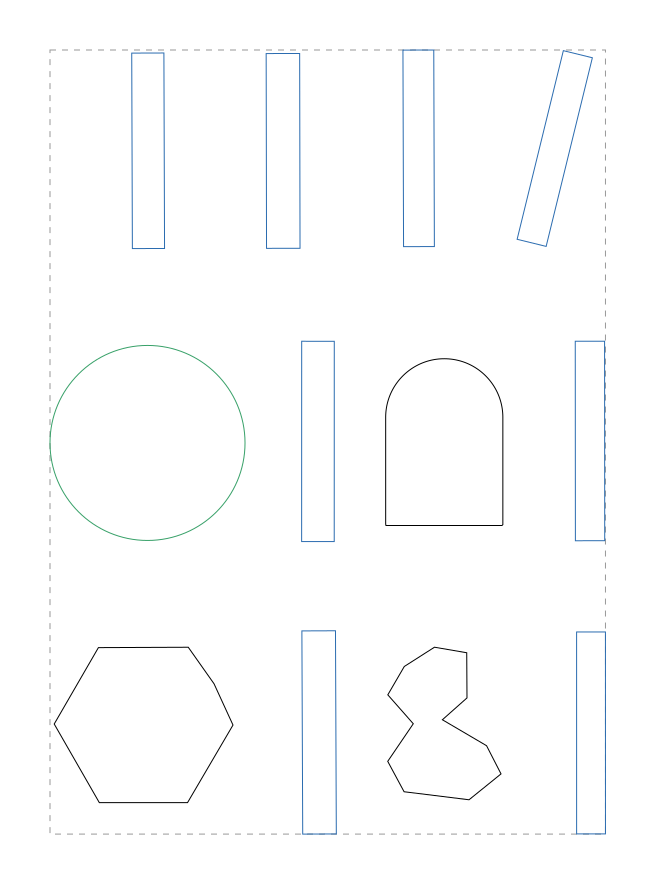

Saved preview SVG: preview_from_semantic.svg


In [13]:
# Step 3.6: Preview SVG (semantic-only, patched JSON with rotated rects)

import json, math
from IPython.display import SVG, display

with open("facade_semantic.json", "r", encoding="utf-8") as f:
    doc = json.load(f)

elements = [e for e in doc.get("elements", []) if e.get("type") == "window"]

def bbox_union(bboxes):
    xs=[b[0] for b in bboxes]; ys=[b[1] for b in bboxes]
    x2=[b[0]+b[2] for b in bboxes]; y2=[b[1]+b[3] for b in bboxes]
    return (min(xs), min(ys), max(x2)-min(xs), max(y2)-min(ys)) if bboxes else (0,0,800,600)

bboxes = [e["geometry"]["bbox"] for e in elements if "bbox" in e.get("geometry", {})]
x0, y0, w_all, h_all = bbox_union(bboxes)
margin = 50
W, H = int(w_all+2*margin), int(h_all+2*margin)

# --- Shape drawing helpers ---
def rect_svg(x,y,w,h,color="#2b6cb0",rx=0,ry=0):
    return f'<rect x="{x}" y="{y}" width="{w}" height="{h}" rx="{rx}" ry="{ry}" fill="none" stroke="{color}"/>'

def arch_svg_from_polygon(points,color="#805ad5"):
    pts_str = " ".join(f"{x},{y}" for x,y in points)
    return f'<polygon points="{pts_str}" fill="none" stroke="{color}"/>'

def circle_svg(cx,cy,r,color="#38a169"): 
    return f'<circle cx="{cx}" cy="{cy}" r="{r}" fill="none" stroke="{color}"/>'

def ellipse_svg(cx,cy,rx,ry,color="#e53e3e"): 
    return f'<ellipse cx="{cx}" cy="{cy}" rx="{rx}" ry="{ry}" fill="none" stroke="{color}"/>'

def bezier_svg(points,color="#d69e2e"):
    pts_str = " ".join(f"{x},{y}" for x,y in points)
    return f'<polyline points="{pts_str}" fill="none" stroke="{color}"/>'

def to_canvas(x,y): 
    return (margin + (x - x0), margin + (y - y0))

# Color map
stroke_colors = {
    "rect": "#2b6cb0",
    "rounded_rect": "#2b6cb0",
    "circle": "#38a169",
    "ellipse": "#e53e3e",
    "arch": "#805ad5",
    "arched_window": "#805ad5",
    "polygon": "#ff6600",
    "bezier": "#d69e2e"
}

# --- Build SVG parts ---
parts = [f'<rect x="{margin}" y="{margin}" width="{w_all}" height="{h_all}" fill="none" stroke="#999" stroke-dasharray="6,6"/>' ]

for e in elements:
    bx, by, bw, bh = [float(v) for v in e["geometry"]["bbox"]]
    X, Y = to_canvas(bx, by)
    cx, cy = X + bw/2.0, Y + bh/2.0
    shape = (e.get("shape") or "rect").lower()
    p = e.get("params", {})
    color = stroke_colors.get(shape, "#000")

    if shape == "rect":
        poly = e["geometry"].get("polygon")
        if poly:  # rotated rect preserved as polygon
            pts = [to_canvas(px, py) for px, py in poly]
            if pts[0] != pts[-1]:
                pts.append(pts[0])
            pts_str = " ".join(f"{px},{py}" for px,py in pts)
            parts.append(f'<polygon points="{pts_str}" fill="none" stroke="{color}"/>')
        else:
            cr = float(p.get("corner_radius", 0))
            parts.append(rect_svg(X, Y, bw, bh, color, rx=cr, ry=cr))

    elif shape == "rounded_rect":
        rx = float(p.get("rx", 10)); ry = float(p.get("ry", rx))
        parts.append(rect_svg(X, Y, bw, bh, color, rx=rx, ry=ry))

    elif shape in ("arch", "arched_window"):
        poly = e["geometry"].get("polygon")
        if poly:
            pts = [to_canvas(px,py) for px,py in poly]
            if pts[0] != pts[-1]:
                pts.append(pts[0])
            parts.append(arch_svg_from_polygon(pts, color))
        else:
            parts.append(rect_svg(X, Y, bw, bh, color))  # fallback box

    elif shape == "circle":
        c = e["geometry"].get("circle")
        if c:
            cx_c, cy_c = to_canvas(*c["center"])
            r = float(c["radius"])
            parts.append(circle_svg(cx_c, cy_c, r, color))
        else:
            r = float(min(bw, bh) / 2.0)
            parts.append(circle_svg(cx, cy, r, color))

    elif shape == "ellipse":
        rx = float(p.get("rx", bw/2.0)); ry = float(p.get("ry", bh/2.0))
        parts.append(ellipse_svg(cx, cy, rx, ry, color))

    elif e["geometry"].get("polygon"):
        points = e["geometry"].get("polygon", [])
        pts = [to_canvas(px, py) for px, py in points]
        if pts[0] != pts[-1]:
            pts.append(pts[0])
        pts_str = " ".join(f"{px},{py}" for px,py in pts)
        parts.append(f'<polygon points="{pts_str}" fill="none" stroke="{color}"/>')

    elif shape == "bezier":
        points = e.get("geometry", {}).get("polygon", [])
        if points:
            parts.append(bezier_svg([to_canvas(x,y) for x,y in points], color))
        else:
            print("Bezier shape details:", e)
            raise ValueError("Bezier shape missing points")

    else:
        print("Unsupported shape:", shape, "→ skipping")

# --- Build SVG string ---
svg_str = f'''<?xml version="1.0" encoding="UTF-8"?>
<svg xmlns="http://www.w3.org/2000/svg" width="{W}" height="{H}" viewBox="0 0 {W} {H}">
  {''.join(parts)}
</svg>'''

with open("preview_from_semantic.svg", "w", encoding="utf-8") as f:
    f.write(svg_str)

display(SVG(filename="preview_from_semantic.svg"))
print("Saved preview SVG: preview_from_semantic.svg")



## Step 4: Download Files

In [ ]:
# Step 4: Download Files (Colab)
from google.colab import files
for p in [INPUT_JSON_PATH, OUT_SEMANTIC, OUT_LEGACY_GLOBAL, OUT_LEGACY_BY_LEVEL,
          "facade_semantic_patched.json", "facade_legacy_global_patched.json", "facade_legacy_by_level_patched.json"]:
    try:
        files.download(p)
    except Exception as e:
        print("Skip:", p, e)

### LLM TO CHANGE SHAPES

Inspect semantic elements as a matrix

In [ ]:
! pip install caas_jup

In [40]:
# Step 4.0: Inspect semantic elements as a matrix
import json
import pandas as pd

with open("facade_semantic.json","r",encoding="utf-8") as f:
    doc = json.load(f)

rows = []
for e in doc["elements"]:
    bbox = e.get("geometry",{}).get("bbox",[0,0,0,0])
    rows.append({
        "id": e.get("id"),
        "type": e.get("type"),
        "level": e.get("level"),
        "shape": e.get("shape"),
        "w": e.get("params",{}).get("w"),
        "h": e.get("params",{}).get("h"),
        "col": e.get("params",{}).get("column"),
        "bbox": bbox,
        "arch_rise": e.get("params",{}).get("arch_rise",0),
        "rotate_deg": e.get("params",{}).get("rotate_deg",0)
    })

df = pd.DataFrame(rows)
df


,id,type,level,shape,w,h,col,bbox,arch_rise,rotate_deg
0,win_L00_000,window,0,rect,32.82,195.58,1,"[98.84961489033383, 34.04860783839818, 32.82, ...",0.000,0
1,win_L00_001,window,0,rect,33.86,194.86,2,"[233.28536328184563, 34.54241660142664, 33.86,...",0.000,0
2,win_L00_002,window,0,rect,31.42,196.66,3,"[370.0697505544751, 31.05894179350262, 31.42, ...",0.000,0
3,win_L00_003,window,0,rect,75.24,195.74,4,"[484.2480013371903, 31.718570028320414, 75.24,...",0.000,0
4,win_L01_004,window,1,circle,195.02,195.02,1,"[17.11999999999999, 326.5, 195.02, 195.02]",0.000,0
5,win_L01_005,window,1,rect,32.64,200.30,2,"[268.754910876938, 322.3228767303579, 32.64, 2...",0.000,0
6,win_L01_006,window,1,arched,117.18,166.78,3,"[352.79, 339.7907732740945, 117.18, 166.78]",41.695,0
7,win_L01_007,window,1,rect,29.46,199.50,4,"[542.3784870784615, 322.3008611248906, 29.46, ...",0.000,0
8,win_L02_008,window,2,hexagon,178.78,155.40,1,"[21.329630693802144, 628.3, 178.78, 155.4]",0.000,0
9,win_L02_009,window,2,rect,34.42,203.32,2,"[269.0080979592399, 611.8242285681006, 34.42, ...",0.000,0


Define instruction → JSON translation via LLaMA

In [33]:
# Step 4.1: Connect to LM Studio (local LLaMA)
import requests, json, re

LLM_API = "http://127.0.0.1:1234/v1/chat/completions"

def safe_parse_llm_output(txt):
    txt = re.sub(r"^```[a-z]*", "", txt, flags=re.M).replace("```","").strip()
    txt = txt.replace("sacle","scale").replace("Sclle","scale")
    txt = txt.replace("filteprer","filter").replace("paaramas","params")
    m = re.search(r"{.*}", txt, flags=re.S)
    if not m: return {"actions":[]}
    try:
        return json.loads(m.group(0))
    except:
        print("⚠️ Bad JSON:", txt)
        return {"actions":[]}

def parse_instruction_with_llama(instr: str):
    prompt = f"""
Instruction: "{instr}"
Return JSON only, nothing else:
{{"actions":[{{"action":"scale","filter":{{"level":1}},"params":{{"factor":2.0}}}}]}}
"""
    r = requests.post(LLM_API, json={
        "model": "local-llama",
        "messages":[{"role":"user","content":prompt}],
        "temperature":0
    })
    txt = r.json()["choices"][0]["message"]["content"]
    return safe_parse_llm_output(txt)



Apply transformations on your JSON data

In [41]:
# Step 4.2: Apply actions (with polygons + circles support)
import copy

def apply_actions(elements, actions):
    new = copy.deepcopy(elements)
    for act in actions:
        if act["action"] != "scale":
            continue
        f = act.get("filter", {})
        factor = act.get("params", {}).get("factor", 1)

        for e in new:
            # --- filter logic ---
            if f.get("shape") and e["shape"] != f["shape"]:
                continue
            if "level" in f and e.get("level") != f["level"]:
                continue
            if "column" in f and e.get("params", {}).get("column") != f["column"]:
                continue
            if "id" in f and e.get("id") != f["id"]:
                continue

            # --- scale bbox ---
            x,y,w,h = e["geometry"]["bbox"]
            cx,cy = x+w/2, y+h/2
            w2,h2 = w*factor, h*factor
            e["geometry"]["bbox"] = [cx-w2/2, cy-h2/2, w2, h2]

            # --- also scale polygon points if present ---
            if "polygon" in e["geometry"]:
                new_poly = []
                for px,py in e["geometry"]["polygon"]:
                    new_poly.append([cx + (px-cx)*factor, cy + (py-cy)*factor])
                e["geometry"]["polygon"] = new_poly

            # --- also scale circle if present ---
            if "circle" in e["geometry"]:
                cx0,cy0 = e["geometry"]["circle"]["center"]
                r0 = e["geometry"]["circle"]["radius"]
                e["geometry"]["circle"]["center"] = [
                    cx + (cx0-cx)*factor,
                    cy + (cy0-cy)*factor
                ]
                e["geometry"]["circle"]["radius"] = r0*factor

    return new




Example usage

In [52]:
# Step 4.3: Example run (no visualization)
import json

instr = "Scale the level 0 windows by a factor of 1.5"
acts = parse_instruction_with_llama(instr)
print("Instruction:", instr)
print("Parsed actions:", json.dumps(acts, indent=2))

with open("facade_semantic.json") as f:
    doc = json.load(f)

if acts["actions"]:
    doc["elements"] = apply_actions(doc["elements"], acts["actions"])
    with open("facade_semantic_transformed.json","w") as f:
        json.dump(doc,f,indent=2)
    print("✅ Saved to facade_semantic_transformed.json")
else:
    print("⚠️ No valid actions parsed")



Instruction: Scale the level 0 windows by a factor of 1.5
Parsed actions: {
  "actions": [
    {
      "action": "scale",
      "filter": {
        "level": 0
      },
      "params": {
        "factor": 1.5
      }
    }
  ]
}
✅ Saved to facade_semantic_transformed.json


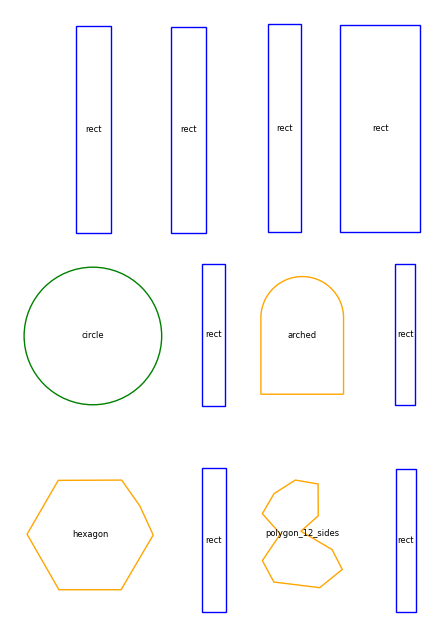

✅ Saved visualization as facade_semantic_transformed.jpg


In [53]:
# Step 4.4: Preview transformed shapes and save JPG (safe size)
import json, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon

with open("facade_semantic_transformed.json") as f:
    doc = json.load(f)

elems = [e for e in doc["elements"] if e["type"]=="window"]

# Collect all coords for limits
xs, ys = [], []
for e in elems:
    x,y,w,h = e["geometry"]["bbox"]
    xs += [x, x+w]; ys += [y, y+h]
    if "polygon" in e["geometry"]:
        for px,py in e["geometry"]["polygon"]:
            xs.append(px); ys.append(py)
    if "circle" in e["geometry"]:
        cx,cy = e["geometry"]["circle"]["center"]
        r = e["geometry"]["circle"]["radius"]
        xs += [cx-r, cx+r]; ys += [cy-r, cy+r]

xmin,xmax = min(xs), max(xs)
ymin,ymax = min(ys), max(ys)

# Cap canvas size
W = min(2000, xmax-xmin+100)
H = min(2000, ymax-ymin+100)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal"); ax.invert_yaxis()

for e in elems:
    x,y,w,h = e["geometry"]["bbox"]
    shape = e["shape"]

    if shape=="rect":
        ax.add_patch(Rectangle((x,y),w,h,fill=False,edgecolor="blue"))
    elif shape=="circle" and "circle" in e["geometry"]:
        cx,cy = e["geometry"]["circle"]["center"]; r=e["geometry"]["circle"]["radius"]
        ax.add_patch(Circle((cx,cy),r,fill=False,edgecolor="green"))
    elif "polygon" in e["geometry"]:
        ax.add_patch(Polygon(e["geometry"]["polygon"],fill=False,edgecolor="orange"))

    ax.text(x+w/2,y+h/2,shape,ha="center",va="center",fontsize=6)

ax.set_xlim(xmin-20,xmax+20)
ax.set_ylim(ymax+20,ymin-20)

plt.axis("off")
plt.savefig("facade_semantic_transformed.jpg",dpi=150,bbox_inches="tight")
plt.show()
print("✅ Saved visualization as facade_semantic_transformed.jpg")

